In [92]:
import pandas as pd
import numpy as np
import catboost as cb
import seaborn as sns
import matplotlib.pyplot as plt 
from tqdm import tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, KBinsDiscretizer
from sklearn.metrics import mean_squared_error

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Flatten, Dense, BatchNormalization, Dropout, MaxPooling2D, AveragePooling2D, Activation, Embedding, MaxPooling1D, Concatenate, Input
from tensorflow.keras.callbacks import EarlyStopping

class CatBoostEvalMetricPearson(object):
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        preds = np.array(approxes[0])
        target = np.array(target)

        return np.corrcoef(target, preds)[0, 1], 0.0

def pearson_metric(y_true, y_pred):
    y_true = K.clip(y_true, K.epsilon(), 1)
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    # normalizing stage - setting a 0 mean.
    y_true -= K.mean(y_true, axis=-1)
    y_pred -= K.mean(y_pred, axis=-1)
    # normalizing stage - setting a 1 variance
    y_true = K.l2_normalize(y_true, axis=-1)
    y_pred = K.l2_normalize(y_pred, axis=-1)
    # final result
    pearson_correlation = K.sum(y_true * y_pred, axis=-1)
    return pearson_correlation

In [3]:
df = pd.read_csv('rna.csv')

In [11]:
def onehot_encode(seq: str, pad: int = 11):
    dt = {
        "a": [[1], [0], [0], [0]],
        "g": [[0], [1], [0], [0]],
        "c": [[0], [0], [1], [0]],
        "u": [[0], [0], [0], [1]],
    }

    res = [[[0]] * 4] * pad + [dt[b.lower()] for b in seq] + [[[0]] * 4] * pad
    return res

X = np.array(df['Sequence'].apply(onehot_encode).tolist())
y = df['Activity'].to_numpy().reshape(-1, 1)

In [118]:
def create_max_filter(k: int):
    model = keras.Sequential([
        Conv2D(1, kernel_size=(k, 4), activation='relu'),
        MaxPooling2D((42 - k, 1)),
        Flatten(),
    ])

    return model

def create_avg_filter(k: int):
    model = keras.Sequential([
        Conv2D(1, kernel_size=(k, 4), activation='relu'),
        AveragePooling2D((42 - k, 1)),
        Flatten(),
    ])

    return model

def create_filter(k: int):
    model = keras.Sequential([
        Conv2D(2, kernel_size=(k, 4), activation='relu'),
        Flatten(),
        Dense(4, activation='relu')
    ])

    return model

In [125]:
inp = Input(shape=X.shape[1:])
# con = Concatenate()([create_max_filter(i)(inp) for i in range(4, 20)] + [create_avg_filter(i)(inp) for i in range(4, 20)])
con = Concatenate()([create_filter(i)(inp) for i in range(4, 20)])
den2 = Dense(24, activation='relu')(con)
den3 = Dense(1, activation='sigmoid')(den2)
model = keras.Model(inputs=[inp], outputs=den3)
model.summary()

Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 41, 4, 1)]   0                                            
__________________________________________________________________________________________________
sequential_588 (Sequential)     (None, 4)            342         input_29[0][0]                   
__________________________________________________________________________________________________
sequential_589 (Sequential)     (None, 4)            342         input_29[0][0]                   
__________________________________________________________________________________________________
sequential_590 (Sequential)     (None, 4)            342         input_29[0][0]                   
___________________________________________________________________________________________

In [126]:
model.compile(loss='mse', optimizer='adam', metrics=[pearson_metric])

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1111111)

In [128]:
earlystopping = EarlyStopping(min_delta=0.0003, patience=4, restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[earlystopping])

Epoch 1/100
61/61 [==============================] - 53s 830ms/step - loss: 0.0230 - pearson_metric: 0.1215 - val_loss: 0.0152 - val_pearson_metric: 0.5102
Epoch 2/100
61/61 [==============================] - 51s 829ms/step - loss: 0.0165 - pearson_metric: 0.5657 - val_loss: 0.0141 - val_pearson_metric: 0.5748
Epoch 3/100
61/61 [==============================] - 50s 811ms/step - loss: 0.0137 - pearson_metric: 0.6006 - val_loss: 0.0131 - val_pearson_metric: 0.5933
Epoch 4/100
61/61 [==============================] - 51s 833ms/step - loss: 0.0126 - pearson_metric: 0.6558 - val_loss: 0.0138 - val_pearson_metric: 0.5857
Epoch 5/100
61/61 [==============================] - 49s 797ms/step - loss: 0.0118 - pearson_metric: 0.6776 - val_loss: 0.0131 - val_pearson_metric: 0.5981
Epoch 6/100
61/61 [==============================] - 49s 812ms/step - loss: 0.0108 - pearson_metric: 0.7050 - val_loss: 0.0130 - val_pearson_metric: 0.6012
Epoch 7/100
61/61 [==============================] - 50s 814ms/s

In [129]:
y_pred = model.predict(X_test)

np.corrcoef(y_test.ravel(), y_pred.ravel())

array([[1.        , 0.55645382],
       [0.55645382, 1.        ]])

<AxesSubplot:>

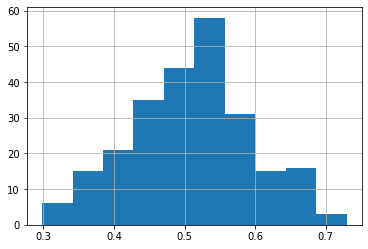

In [100]:
pd.Series(y_pred.ravel()).hist()

In [ ]:
array([[1.       , 0.6835243],
       [0.6835243, 1.       ]])

In [82]:
model.save('cnn_2432_0.7210')

2022-07-10 01:39:35.126510: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: cnn_2432_0.7210/assets


In [83]:
np.save('test_7210', X_test)

In [86]:
np.save('val_7210', X_val)